# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
# taken from previous note book
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])



#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

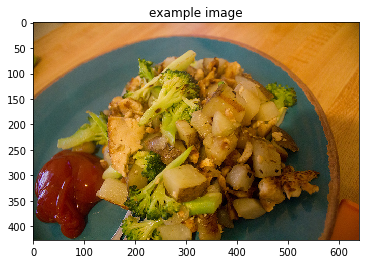

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [3]:
print(image)

tensor([[[[ 1.6495,  1.6495,  1.6667,  ...,  0.9817,  0.8789,  0.8447],
          [ 1.7009,  1.6838,  1.7352,  ...,  0.9474,  0.8789,  0.9132],
          [ 1.7180,  1.7352,  1.7352,  ...,  0.9303,  0.9303,  0.9988],
          ...,
          [-0.1657, -0.5767, -0.5082,  ...,  0.2453,  0.3309,  0.3138],
          [-0.4568, -0.6281, -0.6109,  ...,  0.2282,  0.3309,  0.3309],
          [-0.6281, -0.5253, -0.5424,  ...,  0.2282,  0.3138,  0.3309]],

         [[ 0.5553,  0.5903,  0.6078,  ..., -0.0049, -0.0749, -0.0924],
          [ 0.6254,  0.6429,  0.6954,  ..., -0.0399, -0.0574, -0.0224],
          [ 0.6604,  0.6954,  0.7129,  ..., -0.0399, -0.0049,  0.0651],
          ...,
          [ 0.0826, -0.3375, -0.3375,  ..., -1.0553, -1.0028, -1.0378],
          [-0.1975, -0.4426, -0.4076,  ..., -1.0553, -0.9853, -1.0203],
          [-0.3725, -0.3200, -0.3550,  ..., -1.0553, -1.0203, -1.0203]],

         [[-0.3055, -0.2358, -0.2184,  ..., -1.6650, -1.7347, -1.7347],
          [-0.2010, -0.1661, -

In [4]:
import torch

device_name = "cuda" if torch.cuda.is_available() else "cpu"
print('device_name={}'.format(device_name))
device = torch.device(device_name)

device_name=cuda


<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [7]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
# may need to change the name of the files to match what is saved.
encoder_file = 'encoder-3.pkl' 
decoder_file = 'decoder-3.pkl'

# TODO #3: Select appropriate values for the Python variables below.
# as per our embedding settings defined previously
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (embed): Embedding(9955, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

In [9]:
%reload_ext autoreload



<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [10]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)
## look at image- yes differnt image so OK here also.
print(image)
# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)
## what is our features like returning different tensor so OK here
print(features)
# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
## ISSUE: returing the same sentance from sample.py every time for diff
## images.
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

tensor([[[[ 1.6495,  1.6495,  1.6667,  ...,  0.9817,  0.8789,  0.8447],
          [ 1.7009,  1.6838,  1.7352,  ...,  0.9474,  0.8789,  0.9132],
          [ 1.7180,  1.7352,  1.7352,  ...,  0.9303,  0.9303,  0.9988],
          ...,
          [-0.1657, -0.5767, -0.5082,  ...,  0.2453,  0.3309,  0.3138],
          [-0.4568, -0.6281, -0.6109,  ...,  0.2282,  0.3309,  0.3309],
          [-0.6281, -0.5253, -0.5424,  ...,  0.2282,  0.3138,  0.3309]],

         [[ 0.5553,  0.5903,  0.6078,  ..., -0.0049, -0.0749, -0.0924],
          [ 0.6254,  0.6429,  0.6954,  ..., -0.0399, -0.0574, -0.0224],
          [ 0.6604,  0.6954,  0.7129,  ..., -0.0399, -0.0049,  0.0651],
          ...,
          [ 0.0826, -0.3375, -0.3375,  ..., -1.0553, -1.0028, -1.0378],
          [-0.1975, -0.4426, -0.4076,  ..., -1.0553, -0.9853, -1.0203],
          [-0.3725, -0.3200, -0.3550,  ..., -1.0553, -1.0203, -1.0203]],

         [[-0.3055, -0.2358, -0.2184,  ..., -1.6650, -1.7347, -1.7347],
          [-0.2010, -0.1661, -

<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [53]:
# TODO #4: Complete the function.
def clean_sentence(output):
    ''' from built in function data_loader.dataset.vocab.idx2word ( as described above)
    pass the generated output from sample function
    append the generated word into a list of words( sentance)
    as per course notes drop the first and last tokens'''
    
    words = [] # create container
    
    for word in output:
        # pass generated output word to data_loader.dataset.vocab.idx2word 
        # append into container
        generated_word = data_loader.dataset.vocab.idx2word[word]
        words.append(generated_word)
    
    # remove the <start>// <end> tokens
    #print(words)-debug
    
    word_string=' '.join(words) # creat a str to pass assertion test.
    word_rem1 = word_string.replace('<start>', '') # remove the word <start> which from the notes in the 1st token
    sentence= word_rem1.replace('<end>', '') # remove the word <end> which from the notes in the last token
    
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [54]:
sentence = clean_sentence(output)

print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence:  a plate of food with broccoli and a bowl of soup . 


ok that works.

<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [13]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

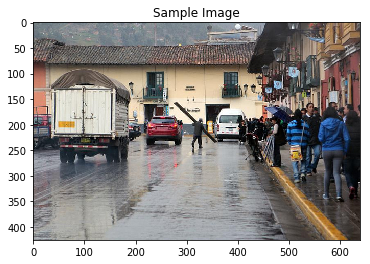

a truck with a large clock on the side of it .


In [14]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

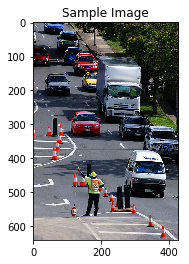

a truck with a large truck on the side of the road .


In [16]:
get_prediction()

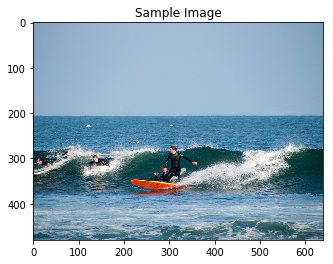

a man riding a surfboard on a wave in the ocean .


In [17]:
get_prediction()

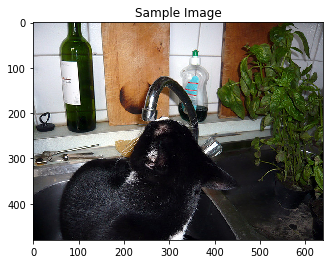

a black and white cat sitting on a table .


In [18]:
get_prediction()

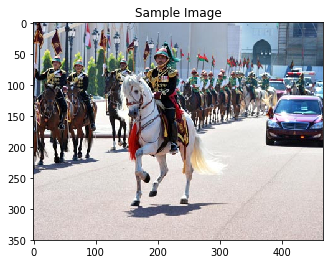

 a group of people riding horses down a street . 


In [57]:
get_prediction()

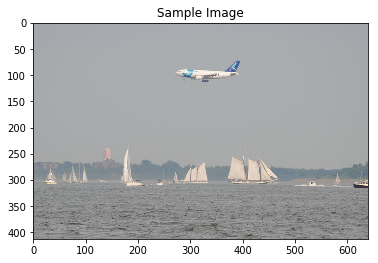

 a large airplane flying over a large body of water . 


In [58]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

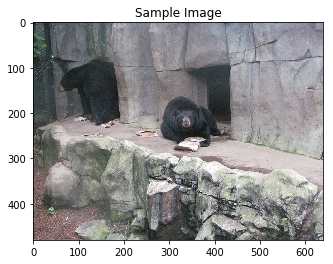

 a bear is walking in the middle of a forest . 


In [55]:
get_prediction()

ok its a Bear but not a forest!!

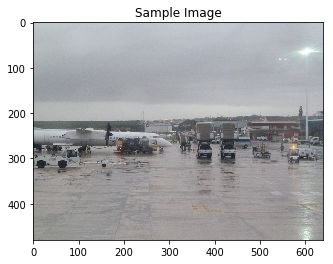

 a group of people riding on a boat in the water . 


In [60]:
get_prediction()

Certainly incorrect-however this took 10 tries to get a completly incorrect caption.

### References:
- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
- https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
- https://www.kaggle.com/code/fanbyprinciple/pytorch-image-captioning-with-flickr/notebook
- https://knowledge.udacity.com/questions/829329
- https://knowledge.udacity.com/questions/829329
- `https://knowledge.udacity.com/questions/530109` -answered my same question
- https://github.com/jckuri/Image-Captioning/blob/master/2_Training.ipynb
- https://towardsdatascience.com/how-to-build-an-image-captioning-model-in-pytorch-29b9d8fe2f8c
- https://medium.com/@deepeshrishu09/automatic-image-captioning-with-pytorch-cf576c98d319

### ** Thanks for reviewing **